In [ ]:
# The function implementation below is a modification version from Tensorflow
# Original code link: https://github.com/ashesh6810/DDWP-DA/blob/master/Unet_STN_lead12.ipynb

In [1]:
# Basic setting for Jupyter_notebook to import utils
import os
import sys

notebook_path = os.path.abspath("")
project_root = os.path.abspath(os.path.join(notebook_path, "../../"))

sys.path.append(project_root)

In [2]:
import netCDF4 as nc

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.io as sio
from tqdm import tqdm

In [4]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import folder_utils

In [5]:
# Example usage

country = "GB"
data_folder = "data"
data_test_category = "test_data"
data_read_category = "raw_data"
data_save_category = "processed_data"
output_folder = "ERA5_DATA"
ddeg_out_lat = 0.25
ddeg_out_lon = 0.125

In [6]:
import tensorflow
import keras.backend as K
# from tensorflow.contrib import keras
# from tensorflow.contrib.keras import backend as K

#from data_manager import ClutteredMNIST
#from visualizer import plot_mnist_sample
#from visualizer import print_evaluation
#from visualizer import plot_mnist_grid
# import netCDF4 as nc

from keras.layers import Input, Convolution2D, Convolution1D, MaxPooling2D, Dense, Dropout, \
                          Flatten, concatenate, Activation, Reshape, \
                          UpSampling2D,ZeroPadding2D
import keras
from keras.callbacks import History
history = History()

import keras
from keras.layers import Conv2D, Conv2DTranspose, Cropping2D, Concatenate, ZeroPadding2D
from keras.models import load_model
from keras.layers import Input
from keras.models import Model
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense

from utils import model_utils_tf
from bilinear_interpolation_1x import BilinearInterpolation

D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

In [7]:
def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights

In [8]:
losses = []  # 用于存储每个 epoch 的训练损失
val_losses = []  # 用于存储每个 epoch 的验证损失

In [9]:
def stn(input_shape=(32, 64, 1), sampling_size=(8, 16), num_classes=10):
    inputs = Input(shape=input_shape)
    conv1 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(pool2)
#     conv3 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv3)


    conv5 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv3)
#     conv5 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv5)
    
    locnet = Flatten()(conv5)
    locnet = Dense(500)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(200)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(100)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(50)(locnet)
    locnet = Activation('relu')(locnet)
    weights = get_initial_weights(50)
    locnet = Dense(6, weights=weights)(locnet)
    x = BilinearInterpolation(sampling_size)([inputs, locnet])


    up6 = keras.layers.Concatenate(axis=-1)([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(x)), conv2])
    conv6 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv6)

    up7 = keras.layers.Concatenate(axis=-1)([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv6)), conv1])
    conv7 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv7)



    conv10 = Convolution2D(1, 5, 5, activation='linear',border_mode='same')(conv7)

    model = Model(input=inputs, output=conv10)



    return model

In [10]:
model = stn()
model.compile(loss='mse', optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  import sys
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 64, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 64, 32)   25632       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), activation="linear", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [11]:
fileList_train = []
fileList_validation =[]
fileList_test=[]
input_folder_path = folder_utils.find_folder(
    country, data_folder, data_save_category, output_folder
)

for year in range (1979,2021):
    file_path =  os.path.join(input_folder_path, f"era5_pressure_level_{year}_regrid_filter_850.nc")
    fileList_train.append (file_path)
    
fileList_validation.append(os.path.join(input_folder_path, f"era5_pressure_level_2021_regrid_filter_850.nc"))
fileList_test.append(os.path.join(input_folder_path, f"era5_pressure_level_2022_regrid_filter_850.nc"))


In [12]:
input_folder_path

'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA'

In [13]:
fileList_train

['F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1979_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1980_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1981_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1982_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1983_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1984_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_1985_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\p

In [14]:
M = 273.77817
sdev = 2.5819736

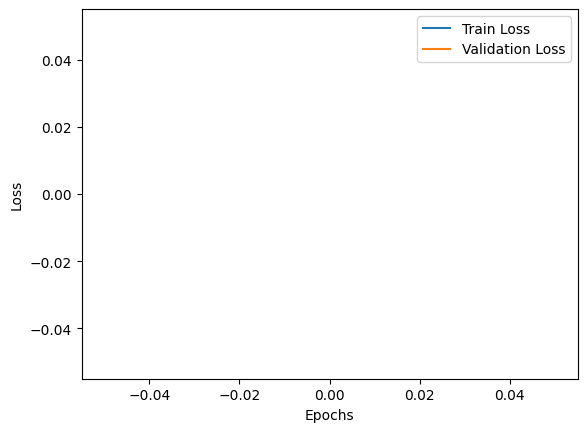

In [15]:
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
File=nc.Dataset(fileList_train[0])
File

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    regrid_method: bilinear
    Conventions: CF-1.6
    history: 2023-08-26 11:48:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data6/adaptor.mars.internal-1693050523.9571652-30807-11-9f2e4cee-f5dd-4cb7-bd14-d8cfa9322780.nc /cache/tmp/9f2e4cee-f5dd-4cb7-bd14-d8cfa9322780-adaptor.mars.internal-1693050488.2242575-30807-18-tmp.grib
    dimensions(sizes): time(8760), lat(32), lon(64)
    variables(dimensions): float32 t(time, lat, lon), int32 time(time), float64 lon(lon), float64 lat(lat)
    groups: 

In [17]:
Z=np.asarray(File['t'])
# Filter out zero and NaN values
Z.shape

(8760, 32, 64)

In [18]:
Z[0]

array([[261.73975, 261.64294, 261.54614, ..., 260.0619 , 260.09912,
        260.09912],
       [261.7046 , 261.5629 , 261.42117, ..., 259.8187 , 259.87036,
        259.87036],
       [261.7162 , 261.5668 , 261.41742, ..., 259.6002 , 259.62454,
        259.62454],
       ...,
       [261.46216, 261.42407, 261.38602, ..., 256.72403, 256.6516 ,
        256.6516 ],
       [261.79437, 261.66544, 261.5366 , ..., 256.6801 , 256.59903,
        256.59903],
       [262.21606, 262.0862 , 261.95657, ..., 256.4985 , 256.44095,
        256.44095]], dtype=float32)

In [16]:
Z[500][6]

array([270.38263, 270.43054, 270.47824, 270.53998, 270.6015 , 270.64752,
       270.69333, 270.71683, 270.7401 , 270.7686 , 270.79678, 270.85736,
       270.91766, 270.99496, 271.072  , 271.1141 , 271.156  , 271.10828,
       271.0604 , 270.9365 , 270.8125 , 270.69632, 270.58   , 270.54492,
       270.50964, 270.5439 , 270.57794, 270.60828, 270.63837, 270.62006,
       270.6015 , 270.54102, 270.4803 , 270.39453, 270.30853, 270.19342,
       270.07806, 269.91208, 269.74585, 269.51465, 269.2832 , 268.9912 ,
       268.69897, 268.4043 , 268.1093 , 267.90137, 267.6931 , 267.61523,
       267.53708, 267.53424, 267.53125, 267.5127 , 267.49405, 267.43845,
       267.38272, 267.3447 , 267.30658, 267.33893, 267.37112, 267.48727,
       267.6033 , 267.79468, 267.98605, 267.98605], dtype=float32)

In [19]:
trainN=np.size(Z,0)-300
trainN

8460

In [53]:
# mask = np.all(~np.isnan(Z), axis=(1, 2))
# Z = Z[mask]

In [105]:
Z

array([[[261.73975, 261.64294, 261.54614, ..., 260.0619 , 260.09912,
         260.09912],
        [261.7046 , 261.5629 , 261.42117, ..., 259.8187 , 259.87036,
         259.87036],
        [261.7162 , 261.5668 , 261.41742, ..., 259.6002 , 259.62454,
         259.62454],
        ...,
        [261.46216, 261.42407, 261.38602, ..., 256.72403, 256.6516 ,
         256.6516 ],
        [261.79437, 261.66544, 261.5366 , ..., 256.6801 , 256.59903,
         256.59903],
        [262.21606, 262.0862 , 261.95657, ..., 256.4985 , 256.44095,
         256.44095]],

       [[261.59326, 261.47308, 261.3529 , ..., 259.57553, 259.56784,
         259.56784],
        [261.50928, 261.3765 , 261.24365, ..., 259.3987 , 259.39575,
         259.39575],
        [261.43893, 261.31006, 261.18115, ..., 259.36264, 259.32166,
         259.32166],
        ...,
        [261.84695, 261.7033 , 261.5598 , ..., 256.76602, 256.68506,
         256.68506],
        [262.0327 , 261.89386, 261.75513, ..., 256.7269 , 256.62054,
   

In [20]:
Z=(Z-M)/sdev

In [21]:
Z

array([[[-4.6624885, -4.69998  , -4.737471 , ..., -5.312323 ,
         -5.2979035, -5.2979035],
        [-4.6761045, -4.7309823, -4.785872 , ..., -5.4065127,
         -5.3865023, -5.3865023],
        [-4.671613 , -4.7294693, -4.787326 , ..., -5.49114  ,
         -5.481708 , -5.481708 ],
        ...,
        [-4.7699986, -4.784749 , -4.799488 , ..., -6.6050787,
         -6.6331263, -6.6331263],
        [-4.6413317, -4.691269 , -4.7411704, ..., -6.622087 ,
         -6.653491 , -6.653491 ],
        [-4.47801  , -4.5283017, -4.5785108, ..., -6.6924243,
         -6.714716 , -6.714716 ]],

       [[-4.719222 , -4.765767 , -4.812312 , ..., -5.5006905,
         -5.503669 , -5.503669 ],
        [-4.751749 , -4.8031754, -4.8546257, ..., -5.5691724,
         -5.5703187, -5.5703187],
        [-4.778993 , -4.8289065, -4.878832 , ..., -5.5831428,
         -5.5990167, -5.5990167],
        ...,
        [-4.6209664, -4.676601 , -4.732176 , ..., -6.5888147,
         -6.620172 , -6.620172 ],
        [-4.

In [19]:
batch_size = 10
num_epochs = 8
lead=12
count=0

In [20]:
x_train=Z[0:trainN,:,:]
x_train=x_train.reshape([np.size(x_train,0),32,64,1])
y_train=Z[lead:trainN+lead,:,:]
y_train=y_train.reshape([np.size(y_train,0),32,64,1])

x_val= Z[trainN+lead:np.size(Z,0)-lead,:,:]
x_val=x_val.reshape([np.size(x_val,0),32,64,1])

y_val= Z[trainN+lead*2:np.size(Z,0),:,:]
y_val=y_val.reshape([np.size(y_val,0),32,64,1])

NameError: name 'trainN' is not defined

In [24]:
# Check for NaN values
if np.isnan(x_train).any() or np.isnan(y_train).any() or np.isnan(x_val).any() or np.isnan(y_val).any():
    print("Found NaN values in data, skipping this file:")

else:
    print("nan!!!")

nan!!!


In [42]:
Z[6609][0]

array([-5.923532 , -5.909916 , -5.896288 , -5.864884 , -5.8334675,
       -5.8014016, -5.7693353, -5.7389827, -5.708642 , -5.6810675,
       -5.6534925, -5.6470747, -5.6406684, -5.6531615, -5.6656547,
       -5.6648626, -5.664071 , -5.634912 , -5.6057534, -5.5641727,
       -5.52258  , -5.4768977, -5.4312034, -5.3766446, -5.322098 ,
       -5.266156 , -5.2102265, -5.165596 , -5.120966 , -5.0831437,
       -5.0453215, -5.0070972, -4.9688845, -4.939395 , -4.9099054,
       -4.8974123, -4.884919 , -4.8814797, -4.8780403, -4.879234 ,
       -4.880416 , -4.886432 , -4.892448 , -4.9000597, -4.90766  ,
       -4.913345 , -4.91903  , -4.928486 , -4.937941 , -4.9503756,
       -4.9628096, -4.9617577, -4.960694 , -4.940979 , -4.9212756,
       -4.8978143, -4.8743405, -4.8531837, -4.832015 , -4.805965 ,
       -4.779915 , -4.746596 , -4.713265 , -4.713265 ], dtype=float32)

In [25]:
nan_indices_x_train = (
    np.array([6610, 6610, 6610, 6780, 6780, 6780, 6780, 6780, 6827, 6827, 6827, 6827, 6827, 6848, 6848, 6848, 7950, 7950, 7950, 7950, 7950, 8166, 8166, 8166]),
    np.array([18, 19, 19, 7, 8, 8, 8, 8, 13, 14, 14, 14, 14, 4, 5, 5, 25, 26, 26, 26, 26, 1, 2, 2]),
    np.array([0, 0, 1, 0, 0, 1, 2, 3, 0, 0, 1, 2, 3, 0, 0, 1, 0, 0, 1, 2, 3, 0, 0, 1])
)

# Loop through the arrays in the tuple and print values
for row_idx, col_idx, channel_idx in zip(*nan_indices_x_train):
    print("Row Index:", row_idx)
    print("Column Index:", col_idx)
    print("Channel Index:", channel_idx)
    print(Z[row_idx][col_idx][channel_idx])
    print("-----")


Row Index: 6610
Column Index: 18
Channel Index: 0
-2.4731073
-----
Row Index: 6610
Column Index: 19
Channel Index: 0
-6.774948
-----
Row Index: 6610
Column Index: 19
Channel Index: 1
-6.774948
-----
Row Index: 6780
Column Index: 7
Channel Index: 0
-2.4583921
-----
Row Index: 6780
Column Index: 8
Channel Index: 0
-6.7855973
-----
Row Index: 6780
Column Index: 8
Channel Index: 1
-6.7855973
-----
Row Index: 6780
Column Index: 8
Channel Index: 2
-6.7855973
-----
Row Index: 6780
Column Index: 8
Channel Index: 3
-6.7855973
-----
Row Index: 6827
Column Index: 13
Channel Index: 0
-6.7793093
-----
Row Index: 6827
Column Index: 14
Channel Index: 0
-2.4690888
-----
Row Index: 6827
Column Index: 14
Channel Index: 1
-2.4690888
-----
Row Index: 6827
Column Index: 14
Channel Index: 2
-2.4690888
-----
Row Index: 6827
Column Index: 14
Channel Index: 3
-2.4690888
-----
Row Index: 6848
Column Index: 4
Channel Index: 0
1.811855
-----
Row Index: 6848
Column Index: 5
Channel Index: 0
-6.7841673
-----
Row In

In [26]:
Z[6848][4]

array([ 1.811855 ,  1.811855 ,  1.8171737,  1.8224925,  1.8282486,
        1.8300924,  1.83196  ,  1.8361086,  1.8402808, -2.4793954,
       -6.801341 , -6.790644 , -6.7845454, -2.4615362,  1.859192 ,
        1.8296788,  1.8002127,  1.7661372,  1.732109 ,  1.7097347,
        1.6874195,  1.686273 ,  1.6851739,  1.7021347,  1.7191548,
        1.7410799,  1.7630523,  1.7785594,  1.7941376,  1.8039596,
        1.8138406,  1.8220788,  1.8303642,  1.8390634,  1.8478216,
       -2.475235 , -6.800549 , -6.78464  , -6.7733054, -6.7471724,
       -6.7233205, -6.684399 , -6.64543  , -6.6012135, -6.5569615,
       -6.5198836, -6.4827704, -6.4544277, -6.4260373, -6.398486 ,
       -6.370899 , -6.3406296, -6.310336 , -6.2823715, -6.2543945,
       -6.225638 , -6.1968694, -6.1628175, -6.1287656, -6.092787 ,
       -6.0568204, -6.026208 , -5.9955955, -5.9955955], dtype=float32)

In [43]:
nan_indices_Z = np.where(np.isnan(Z))
print("NaN indices in x_train:")
print(nan_indices_Z)

NaN indices in x_train:
(array([6610, 6610, 6610, 6780, 6780, 6780, 6780, 6780, 6827, 6827, 6827,
       6827, 6827, 6848, 6848, 6848, 7950, 7950, 7950, 7950, 7950, 8166,
       8166, 8166], dtype=int64), array([18, 19, 19,  7,  8,  8,  8,  8, 13, 14, 14, 14, 14,  4,  5,  5, 25,
       26, 26, 26, 26,  1,  2,  2], dtype=int64), array([0, 0, 1, 0, 0, 1, 2, 3, 0, 0, 1, 2, 3, 0, 0, 1, 0, 0, 1, 2, 3, 0,
       0, 1], dtype=int64))


In [36]:
# Find and print indices of NaN values in x_train
nan_indices_x_train = np.where(np.isnan(x_train))
print("NaN indices in x_train:")
print(nan_indices_x_train)

# Find and print indices of NaN values in y_train
nan_indices_y_train = np.where(np.isnan(y_train))
print("NaN indices in y_train:")
print(nan_indices_y_train)

# Find and print indices of NaN values in x_val
nan_indices_x_val = np.where(np.isnan(x_val))
print("NaN indices in x_val:")
print(nan_indices_x_val)

# Find and print indices of NaN values in y_val
nan_indices_y_val = np.where(np.isnan(y_val))
print("NaN indices in y_val:")
print(nan_indices_y_val)

NaN indices in x_train:
(array([6610, 6610, 6610, 6780, 6780, 6780, 6780, 6780, 6827, 6827, 6827,
       6827, 6827, 6848, 6848, 6848, 7950, 7950, 7950, 7950, 7950, 8166,
       8166, 8166], dtype=int64), array([18, 19, 19,  7,  8,  8,  8,  8, 13, 14, 14, 14, 14,  4,  5,  5, 25,
       26, 26, 26, 26,  1,  2,  2], dtype=int64), array([0, 0, 1, 0, 0, 1, 2, 3, 0, 0, 1, 2, 3, 0, 0, 1, 0, 0, 1, 2, 3, 0,
       0, 1], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64))
NaN indices in y_train:
(array([6598, 6598, 6598, 6768, 6768, 6768, 6768, 6768, 6815, 6815, 6815,
       6815, 6815, 6836, 6836, 6836, 7938, 7938, 7938, 7938, 7938, 8154,
       8154, 8154], dtype=int64), array([18, 19, 19,  7,  8,  8,  8,  8, 13, 14, 14, 14, 14,  4,  5,  5, 25,
       26, 26, 26, 26,  1,  2,  2], dtype=int64), array([0, 0, 1, 0, 0, 1, 2, 3, 0, 0, 1, 2, 3, 0, 0, 1, 0, 0, 1, 2, 3, 0,
       0, 1], dtype=int64), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [30]:
x_train.shape

(8460, 32, 64, 1)

In [31]:
y_train.shape

(8460, 32, 64, 1)

In [27]:
y_val.shape

(276, 32, 64, 1)

In [29]:
x_val.shape

(276, 32, 64, 1)

In [1]:
x_val

NameError: name 'x_val' is not defined

In [23]:
batch_size = 10
num_epochs = 8
lead=12
count=0
for loop in tqdm(fileList_train, desc="Processing files"):
    print('******************** counter*************',count)
    File=nc.Dataset(loop)
    Z=np.asarray(File['t'])
    
# # Create a mask to filter out samples with NaN values
#     mask = np.all(~np.isnan(Z), axis=(1, 2))
#     Z = Z[mask]
    
    trainN=np.size(Z,0)-300
    Z=(Z-M)/sdev
    
    
    x_train=Z[0:trainN,:,:]
    x_train=x_train.reshape([np.size(x_train,0),32,64,1])
    y_train=Z[lead:trainN+lead,:,:]
    y_train=y_train.reshape([np.size(y_train,0),32,64,1])
    
    x_val= Z[trainN+lead:np.size(Z,0)-lead,:,:]
    x_val=x_val.reshape([np.size(x_val,0),32,64,1])
    
    y_val= Z[trainN+lead*2:np.size(Z,0),:,:]
    y_val=y_val.reshape([np.size(y_val,0),32,64,1])

    if (count>0):
        
        model = stn()
        model.compile(loss='mse', optimizer='adam')
        # Modify the HDF5 file before loading weights
#         modify_h5_file('best_weights_lead12.h5')

        model.load_weights('best_weights_lead12.h5')
        hist = model.fit(x_train, y_train,
                       batch_size = batch_size,
             verbose=1,
             epochs = 20,
             validation_data=(x_val,y_val),shuffle=True,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=5, # just to make sure we use a lot of patience before stopping
                                        verbose=0, mode='auto'),
                       keras.callbacks.ModelCheckpoint('best_weights_lead'+str(lead)+'.h5', monitor='val_loss',
                                                    verbose=1, save_best_only=True,
                                                    save_weights_only=True, mode='auto', period=1),history]
             )
        losses.extend(hist.history['loss'])
        val_losses.extend(hist.history['val_loss'])

    else:
        hist = model.fit(x_train, y_train,
                       batch_size = batch_size,
             verbose=1,
             epochs = 20,
             validation_data=(x_val,y_val),shuffle=True,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=5, # just to make sure we use a lot of patience before stopping
                                        verbose=0, mode='auto'),
                       keras.callbacks.ModelCheckpoint('best_weights_lead'+str(lead)+'.h5', monitor='val_loss',
                                                    verbose=1, save_best_only=True,
                                                    save_weights_only=True, mode='auto', period=1),history]
             )
        losses.extend(hist.history['loss'])
        val_losses.extend(hist.history['val_loss'])


    count=count+1

Processing files:   0%|                                                                         | 0/42 [00:00<?, ?it/s]D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  import sys
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\p

******************** counter************* 1


D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (2, 2), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update you

Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 142s 17ms/step - loss: 4.0010 - val_loss: 0.7709

Epoch 00001: val_loss improved from inf to 0.77087, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 146s 17ms/step - loss: 3.9174 - val_loss: 0.7360

Epoch 00002: val_loss improved from 0.77087 to 0.73603, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 147s 17ms/step - loss: 3.7878 - val_loss: 0.8454

Epoch 00003: val_loss did not improve from 0.73603
Epoch 4/20
8460/8460 [==============================] - 149s 18ms/step - loss: 3.7374 - val_loss: 0.8584

Epoch 00004: val_loss did not improve from 0.73603
Epoch 5/20
8460/8460 [==============================] - 151s 18ms/step - loss: 3.6514 - val_loss: 0.8851

Epoch 00005: val_loss did not improve from 0.73603
Epoch 6/20
8460/8460 [==============================] - 156s 18ms/step - loss: 3.569

Processing files:   2%|█▍                                                          | 1/42 [17:27<11:55:37, 1047.25s/it]


Epoch 00007: val_loss did not improve from 0.73603
******************** counter************* 2
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 152s 18ms/step - loss: 2.1476 - val_loss: 1.2994

Epoch 00001: val_loss improved from inf to 1.29942, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 151s 18ms/step - loss: 2.0732 - val_loss: 1.3515

Epoch 00002: val_loss did not improve from 1.29942
Epoch 3/20
8484/8484 [==============================] - 159s 19ms/step - loss: 2.0241 - val_loss: 1.2476

Epoch 00003: val_loss improved from 1.29942 to 1.24763, saving model to best_weights_lead12.h5
Epoch 4/20
8484/8484 [==============================] - 156s 18ms/step - loss: 1.9795 - val_loss: 1.2462

Epoch 00004: val_loss improved from 1.24763 to 1.24619, saving model to best_weights_lead12.h5
Epoch 5/20
8484/8484 [==============================] - 155s 18ms/step - loss: 1.9180 - val_loss: 1.3

Processing files:   5%|██▊                                                         | 2/42 [40:50<13:57:45, 1256.64s/it]


Epoch 00009: val_loss did not improve from 1.24619
******************** counter************* 3
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 156s 18ms/step - loss: 2.0428 - val_loss: 0.7813

Epoch 00001: val_loss improved from inf to 0.78134, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 156s 18ms/step - loss: 1.9539 - val_loss: 0.6108

Epoch 00002: val_loss improved from 0.78134 to 0.61080, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 155s 18ms/step - loss: 1.9070 - val_loss: 0.7263

Epoch 00003: val_loss did not improve from 0.61080
Epoch 4/20
8460/8460 [==============================] - 151s 18ms/step - loss: 1.8502 - val_loss: 0.8362

Epoch 00004: val_loss did not improve from 0.61080
Epoch 5/20
8460/8460 [==============================] - 153s 18ms/step - loss: 1.8049 - val_loss: 0.7265

Epoch 00005: val_loss did not improve f

Processing files:   7%|████▎                                                       | 3/42 [58:57<12:46:26, 1179.15s/it]


Epoch 00007: val_loss did not improve from 0.61080
******************** counter************* 4
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 162s 19ms/step - loss: 2.7523 - val_loss: 1.0127

Epoch 00001: val_loss improved from inf to 1.01274, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 164s 19ms/step - loss: 2.6083 - val_loss: 1.0634

Epoch 00002: val_loss did not improve from 1.01274
Epoch 3/20
8460/8460 [==============================] - 158s 19ms/step - loss: 2.5175 - val_loss: 1.1019

Epoch 00003: val_loss did not improve from 1.01274
Epoch 4/20
8460/8460 [==============================] - 156s 18ms/step - loss: 2.4395 - val_loss: 0.9205

Epoch 00004: val_loss improved from 1.01274 to 0.92051, saving model to best_weights_lead12.h5
Epoch 5/20
8460/8460 [==============================] - 157s 19ms/step - loss: 2.3458 - val_loss: 0.8886

Epoch 00005: val_loss improved from 0.9

Processing files:  10%|█████▌                                                    | 4/42 [1:32:05<15:49:10, 1498.69s/it]


Epoch 00012: val_loss did not improve from 0.86495
******************** counter************* 5
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 179s 21ms/step - loss: 1.9306 - val_loss: 2.1092

Epoch 00001: val_loss improved from inf to 2.10924, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 177s 21ms/step - loss: 1.7971 - val_loss: 2.1875

Epoch 00002: val_loss did not improve from 2.10924
Epoch 3/20
8460/8460 [==============================] - 170s 20ms/step - loss: 1.7155 - val_loss: 2.2175

Epoch 00003: val_loss did not improve from 2.10924
Epoch 4/20
8460/8460 [==============================] - 166s 20ms/step - loss: 1.6329 - val_loss: 2.0908

Epoch 00004: val_loss improved from 2.10924 to 2.09078, saving model to best_weights_lead12.h5
Epoch 5/20
8460/8460 [==============================] - 171s 20ms/step - loss: 1.5894 - val_loss: 2.3486

Epoch 00005: val_loss did not improve f

Processing files:  12%|██████▉                                                   | 5/42 [2:10:04<18:17:32, 1779.78s/it]


Epoch 00009: val_loss did not improve from 2.09078
******************** counter************* 6
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 384s 45ms/step - loss: 1.8174 - val_loss: 1.0114

Epoch 00001: val_loss improved from inf to 1.01141, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 379s 45ms/step - loss: 1.7278 - val_loss: 1.0785

Epoch 00002: val_loss did not improve from 1.01141
Epoch 3/20
8484/8484 [==============================] - 384s 45ms/step - loss: 1.6712 - val_loss: 0.9368

Epoch 00003: val_loss improved from 1.01141 to 0.93680, saving model to best_weights_lead12.h5
Epoch 4/20
8484/8484 [==============================] - 384s 45ms/step - loss: 1.6351 - val_loss: 1.0635

Epoch 00004: val_loss did not improve from 0.93680
Epoch 5/20
8484/8484 [==============================] - 380s 45ms/step - loss: 1.5730 - val_loss: 0.9199

Epoch 00005: val_loss improved from 0.9

Processing files:  14%|████████▎                                                 | 6/42 [3:13:37<24:42:48, 2471.36s/it]


Epoch 00010: val_loss did not improve from 0.91993
******************** counter************* 7
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 389s 46ms/step - loss: 2.8064 - val_loss: 0.4604

Epoch 00001: val_loss improved from inf to 0.46035, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 384s 45ms/step - loss: 2.6673 - val_loss: 0.5721

Epoch 00002: val_loss did not improve from 0.46035
Epoch 3/20
8460/8460 [==============================] - 387s 46ms/step - loss: 2.5706 - val_loss: 0.5056

Epoch 00003: val_loss did not improve from 0.46035
Epoch 4/20
8460/8460 [==============================] - 382s 45ms/step - loss: 2.5060 - val_loss: 0.4894

Epoch 00004: val_loss did not improve from 0.46035
Epoch 5/20
8460/8460 [==============================] - 385s 45ms/step - loss: 2.4460 - val_loss: 0.5050

Epoch 00005: val_loss did not improve from 0.46035
Epoch 6/20
8460/8460 [==========

Processing files:  17%|█████████▋                                                | 7/42 [3:52:25<23:34:07, 2424.22s/it]


Epoch 00006: val_loss did not improve from 0.46035
******************** counter************* 8
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 399s 47ms/step - loss: 2.0845 - val_loss: 0.8869

Epoch 00001: val_loss improved from inf to 0.88689, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 394s 47ms/step - loss: 1.9896 - val_loss: 1.0247

Epoch 00002: val_loss did not improve from 0.88689
Epoch 3/20
8460/8460 [==============================] - 395s 47ms/step - loss: 1.9301 - val_loss: 0.9168

Epoch 00003: val_loss did not improve from 0.88689
Epoch 4/20
8460/8460 [==============================] - 390s 46ms/step - loss: 1.8848 - val_loss: 0.8848

Epoch 00004: val_loss improved from 0.88689 to 0.88481, saving model to best_weights_lead12.h5
Epoch 5/20
8460/8460 [==============================] - 395s 47ms/step - loss: 1.8294 - val_loss: 0.9380

Epoch 00005: val_loss did not improve f

Processing files:  19%|███████████                                               | 8/42 [4:51:45<26:18:45, 2786.05s/it]


Epoch 00009: val_loss did not improve from 0.88481
******************** counter************* 9
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 404s 48ms/step - loss: 4.4300 - val_loss: 6.3056

Epoch 00001: val_loss improved from inf to 6.30563, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 400s 47ms/step - loss: 4.2887 - val_loss: 6.5145

Epoch 00002: val_loss did not improve from 6.30563
Epoch 3/20
8460/8460 [==============================] - 403s 48ms/step - loss: 4.1458 - val_loss: 6.6342

Epoch 00003: val_loss did not improve from 6.30563
Epoch 4/20
8460/8460 [==============================] - 398s 47ms/step - loss: 4.0194 - val_loss: 7.2257

Epoch 00004: val_loss did not improve from 6.30563
Epoch 5/20
8460/8460 [==============================] - 403s 48ms/step - loss: 3.9465 - val_loss: 7.1770

Epoch 00005: val_loss did not improve from 6.30563
Epoch 6/20
8460/8460 [==========

Processing files:  21%|████████████▍                                             | 9/42 [5:32:10<24:30:08, 2672.97s/it]


Epoch 00006: val_loss did not improve from 6.30563
******************** counter************* 10
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 416s 49ms/step - loss: 1.6653 - val_loss: 1.2863

Epoch 00001: val_loss improved from inf to 1.28626, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 417s 49ms/step - loss: 1.5633 - val_loss: 1.2969

Epoch 00002: val_loss did not improve from 1.28626
Epoch 3/20
8484/8484 [==============================] - 419s 49ms/step - loss: 1.5131 - val_loss: 1.1995

Epoch 00003: val_loss improved from 1.28626 to 1.19952, saving model to best_weights_lead12.h5
Epoch 4/20
8484/8484 [==============================] - 419s 49ms/step - loss: 1.4719 - val_loss: 1.3996

Epoch 00004: val_loss did not improve from 1.19952
Epoch 5/20
8484/8484 [==============================] - 413s 49ms/step - loss: 1.4333 - val_loss: 1.3181

Epoch 00005: val_loss did not improve 

Processing files:  24%|█████████████▌                                           | 10/42 [6:27:53<25:35:52, 2879.76s/it]


Epoch 00008: val_loss did not improve from 1.19952
******************** counter************* 11
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 430s 51ms/step - loss: 1.7930 - val_loss: 0.9356

Epoch 00001: val_loss improved from inf to 0.93565, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 423s 50ms/step - loss: 1.6984 - val_loss: 0.9408

Epoch 00002: val_loss did not improve from 0.93565
Epoch 3/20
8460/8460 [==============================] - 429s 51ms/step - loss: 1.6439 - val_loss: 0.8645

Epoch 00003: val_loss improved from 0.93565 to 0.86450, saving model to best_weights_lead12.h5
Epoch 4/20
8460/8460 [==============================] - 427s 51ms/step - loss: 1.5992 - val_loss: 1.0590

Epoch 00004: val_loss did not improve from 0.86450
Epoch 5/20
8460/8460 [==============================] - 425s 50ms/step - loss: 1.5356 - val_loss: 0.9850

Epoch 00005: val_loss did not improve 

Processing files:  26%|██████████████▉                                          | 11/42 [7:25:02<26:14:52, 3048.15s/it]


Epoch 00008: val_loss did not improve from 0.86450
******************** counter************* 12
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 440s 52ms/step - loss: 1.6658 - val_loss: 1.1394

Epoch 00001: val_loss improved from inf to 1.13942, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 436s 52ms/step - loss: 1.6042 - val_loss: 0.9989

Epoch 00002: val_loss improved from 1.13942 to 0.99891, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 438s 52ms/step - loss: 1.5629 - val_loss: 1.0303

Epoch 00003: val_loss did not improve from 0.99891
Epoch 4/20
8460/8460 [==============================] - 437s 52ms/step - loss: 1.5315 - val_loss: 1.2524

Epoch 00004: val_loss did not improve from 0.99891
Epoch 5/20
8460/8460 [==============================] - 439s 52ms/step - loss: 1.5003 - val_loss: 1.0609

Epoch 00005: val_loss did not improve 

Processing files:  29%|████████████████▎                                        | 12/42 [8:16:32<25:30:23, 3060.79s/it]


Epoch 00007: val_loss did not improve from 0.99891
******************** counter************* 13
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 448s 53ms/step - loss: 2.3503 - val_loss: 2.2256

Epoch 00001: val_loss improved from inf to 2.22556, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 442s 52ms/step - loss: 2.2616 - val_loss: 2.5115

Epoch 00002: val_loss did not improve from 2.22556
Epoch 3/20
8460/8460 [==============================] - 441s 52ms/step - loss: 2.2109 - val_loss: 2.2430

Epoch 00003: val_loss did not improve from 2.22556
Epoch 4/20
8460/8460 [==============================] - 441s 52ms/step - loss: 2.1579 - val_loss: 2.6073

Epoch 00004: val_loss did not improve from 2.22556
Epoch 5/20
8460/8460 [==============================] - 443s 52ms/step - loss: 2.1083 - val_loss: 2.2168

Epoch 00005: val_loss improved from 2.22556 to 2.21684, saving model to best_weigh

Processing files:  31%|█████████████████▋                                       | 13/42 [9:30:37<28:02:03, 3480.11s/it]


Epoch 00010: val_loss did not improve from 2.21684
******************** counter************* 14
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 465s 55ms/step - loss: 1.7646 - val_loss: 0.6229

Epoch 00001: val_loss improved from inf to 0.62287, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 465s 55ms/step - loss: 1.6872 - val_loss: 0.6463

Epoch 00002: val_loss did not improve from 0.62287
Epoch 3/20
8484/8484 [==============================] - 467s 55ms/step - loss: 1.6437 - val_loss: 0.6534

Epoch 00003: val_loss did not improve from 0.62287
Epoch 4/20
8484/8484 [==============================] - 464s 55ms/step - loss: 1.6069 - val_loss: 0.6699

Epoch 00004: val_loss did not improve from 0.62287
Epoch 5/20
8484/8484 [==============================] - 464s 55ms/step - loss: 1.5667 - val_loss: 0.6258

Epoch 00005: val_loss did not improve from 0.62287
Epoch 6/20
8484/8484 [=========

Processing files:  33%|██████████████████▋                                     | 14/42 [10:56:31<30:59:56, 3985.61s/it]


Epoch 00011: val_loss did not improve from 0.56316
******************** counter************* 15
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 482s 57ms/step - loss: 1.7892 - val_loss: 0.9819

Epoch 00001: val_loss improved from inf to 0.98189, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 473s 56ms/step - loss: 1.6795 - val_loss: 0.5652

Epoch 00002: val_loss improved from 0.98189 to 0.56518, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 471s 56ms/step - loss: 1.6246 - val_loss: 0.8912

Epoch 00003: val_loss did not improve from 0.56518
Epoch 4/20
8460/8460 [==============================] - 469s 55ms/step - loss: 1.5622 - val_loss: 0.6753

Epoch 00004: val_loss did not improve from 0.56518
Epoch 5/20
8460/8460 [==============================] - 469s 55ms/step - loss: 1.5176 - val_loss: 0.7181

Epoch 00005: val_loss did not improve 

Processing files:  36%|████████████████████                                    | 15/42 [12:23:35<32:41:29, 4358.89s/it]


Epoch 00011: val_loss did not improve from 0.54429
******************** counter************* 16
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 450s 53ms/step - loss: 1.6798 - val_loss: 0.9127

Epoch 00001: val_loss improved from inf to 0.91267, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 483s 57ms/step - loss: 1.5913 - val_loss: 0.8295

Epoch 00002: val_loss improved from 0.91267 to 0.82948, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 482s 57ms/step - loss: 1.5456 - val_loss: 0.8310

Epoch 00003: val_loss did not improve from 0.82948
Epoch 4/20
8460/8460 [==============================] - 481s 57ms/step - loss: 1.5010 - val_loss: 0.8997

Epoch 00004: val_loss did not improve from 0.82948
Epoch 5/20
8460/8460 [==============================] - 480s 57ms/step - loss: 1.4692 - val_loss: 0.9189

Epoch 00005: val_loss did not improve 

Processing files:  38%|█████████████████████▎                                  | 16/42 [13:19:40<29:19:15, 4059.81s/it]


Epoch 00007: val_loss did not improve from 0.82948
******************** counter************* 17
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 502s 59ms/step - loss: 2.4618 - val_loss: 0.5986

Epoch 00001: val_loss improved from inf to 0.59864, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 497s 59ms/step - loss: 2.3643 - val_loss: 0.7818

Epoch 00002: val_loss did not improve from 0.59864
Epoch 3/20
8460/8460 [==============================] - 500s 59ms/step - loss: 2.3000 - val_loss: 1.0814

Epoch 00003: val_loss did not improve from 0.59864
Epoch 4/20
8460/8460 [==============================] - 501s 59ms/step - loss: 2.2491 - val_loss: 0.9855

Epoch 00004: val_loss did not improve from 0.59864
Epoch 5/20
8460/8460 [==============================] - 502s 59ms/step - loss: 2.2049 - val_loss: 0.8361

Epoch 00005: val_loss did not improve from 0.59864
Epoch 6/20
8460/8460 [=========

Processing files:  40%|██████████████████████▋                                 | 17/42 [14:10:07<26:02:10, 3749.24s/it]


Epoch 00006: val_loss did not improve from 0.59864
******************** counter************* 18
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 513s 60ms/step - loss: 3.1703 - val_loss: 0.6448

Epoch 00001: val_loss improved from inf to 0.64482, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 502s 59ms/step - loss: 3.0547 - val_loss: 0.7065

Epoch 00002: val_loss did not improve from 0.64482
Epoch 3/20
8484/8484 [==============================] - 486s 57ms/step - loss: 2.9619 - val_loss: 0.8051

Epoch 00003: val_loss did not improve from 0.64482
Epoch 4/20
8484/8484 [==============================] - 501s 59ms/step - loss: 2.8913 - val_loss: 0.7192

Epoch 00004: val_loss did not improve from 0.64482
Epoch 5/20
8484/8484 [==============================] - 499s 59ms/step - loss: 2.8386 - val_loss: 0.8911

Epoch 00005: val_loss did not improve from 0.64482
Epoch 6/20
8484/8484 [=========

Processing files:  43%|████████████████████████                                | 18/42 [15:00:31<23:32:28, 3531.17s/it]


Epoch 00006: val_loss did not improve from 0.64482
******************** counter************* 19
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 510s 60ms/step - loss: 2.0391 - val_loss: 0.7200

Epoch 00001: val_loss improved from inf to 0.72001, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 515s 61ms/step - loss: 1.9211 - val_loss: 0.5940

Epoch 00002: val_loss improved from 0.72001 to 0.59402, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 517s 61ms/step - loss: 1.8542 - val_loss: 0.6516

Epoch 00003: val_loss did not improve from 0.59402
Epoch 4/20
8460/8460 [==============================] - 518s 61ms/step - loss: 1.8129 - val_loss: 0.6688

Epoch 00004: val_loss did not improve from 0.59402
Epoch 5/20
8460/8460 [==============================] - 517s 61ms/step - loss: 1.7835 - val_loss: 0.7075

Epoch 00005: val_loss did not improve 

Processing files:  45%|█████████████████████████▎                              | 19/42 [16:01:07<22:45:44, 3562.80s/it]


Epoch 00007: val_loss did not improve from 0.59402
******************** counter************* 20
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 525s 62ms/step - loss: 1.3306 - val_loss: 0.9058

Epoch 00001: val_loss improved from inf to 0.90579, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 516s 61ms/step - loss: 1.2635 - val_loss: 0.9763

Epoch 00002: val_loss did not improve from 0.90579
Epoch 3/20
8460/8460 [==============================] - 516s 61ms/step - loss: 1.2277 - val_loss: 1.0510

Epoch 00003: val_loss did not improve from 0.90579
Epoch 4/20
8460/8460 [==============================] - 516s 61ms/step - loss: 1.1832 - val_loss: 0.9196

Epoch 00004: val_loss did not improve from 0.90579
Epoch 5/20
8460/8460 [==============================] - 514s 61ms/step - loss: 1.1466 - val_loss: 1.0287

Epoch 00005: val_loss did not improve from 0.90579
Epoch 6/20
8460/8460 [=========

Processing files:  48%|██████████████████████████▋                             | 20/42 [16:53:16<20:58:33, 3432.45s/it]


Epoch 00006: val_loss did not improve from 0.90579
******************** counter************* 21
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 534s 63ms/step - loss: 1.6193 - val_loss: 0.5961

Epoch 00001: val_loss improved from inf to 0.59611, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 531s 63ms/step - loss: 1.5558 - val_loss: 0.6093

Epoch 00002: val_loss did not improve from 0.59611
Epoch 3/20
8460/8460 [==============================] - 530s 63ms/step - loss: 1.5247 - val_loss: 0.6667

Epoch 00003: val_loss did not improve from 0.59611
Epoch 4/20
8460/8460 [==============================] - 526s 62ms/step - loss: 1.4836 - val_loss: 0.6253

Epoch 00004: val_loss did not improve from 0.59611
Epoch 5/20
8460/8460 [==============================] - 530s 63ms/step - loss: 1.4487 - val_loss: 0.6435

Epoch 00005: val_loss did not improve from 0.59611
Epoch 6/20
8460/8460 [=========

Processing files:  50%|████████████████████████████                            | 21/42 [17:46:45<19:37:55, 3365.50s/it]


Epoch 00006: val_loss did not improve from 0.59611
******************** counter************* 22
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 532s 63ms/step - loss: 1.2741 - val_loss: 0.6760

Epoch 00001: val_loss improved from inf to 0.67602, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 523s 62ms/step - loss: 1.2106 - val_loss: 0.5217

Epoch 00002: val_loss improved from 0.67602 to 0.52168, saving model to best_weights_lead12.h5
Epoch 3/20
8484/8484 [==============================] - 528s 62ms/step - loss: 1.1884 - val_loss: 0.7344

Epoch 00003: val_loss did not improve from 0.52168
Epoch 4/20
8484/8484 [==============================] - 535s 63ms/step - loss: 1.1831 - val_loss: 0.6125

Epoch 00004: val_loss did not improve from 0.52168
Epoch 5/20
8484/8484 [==============================] - 538s 63ms/step - loss: 1.1360 - val_loss: 0.5418

Epoch 00005: val_loss did not improve 

Processing files:  52%|█████████████████████████████▎                          | 22/42 [18:49:48<19:23:34, 3490.73s/it]


Epoch 00007: val_loss did not improve from 0.52168
******************** counter************* 23
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 564s 67ms/step - loss: 1.8820 - val_loss: 1.2167

Epoch 00001: val_loss improved from inf to 1.21670, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 555s 66ms/step - loss: 1.8265 - val_loss: 1.8535

Epoch 00002: val_loss did not improve from 1.21670
Epoch 3/20
8460/8460 [==============================] - 555s 66ms/step - loss: 1.7863 - val_loss: 1.3329

Epoch 00003: val_loss did not improve from 1.21670
Epoch 4/20
8460/8460 [==============================] - 555s 66ms/step - loss: 1.7663 - val_loss: 1.2559

Epoch 00004: val_loss did not improve from 1.21670
Epoch 5/20
8460/8460 [==============================] - 557s 66ms/step - loss: 1.7349 - val_loss: 1.2869

Epoch 00005: val_loss did not improve from 1.21670
Epoch 6/20
8460/8460 [=========

Processing files:  55%|██████████████████████████████▋                         | 23/42 [19:46:02<18:14:19, 3455.76s/it]


Epoch 00006: val_loss did not improve from 1.21670
******************** counter************* 24
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 583s 69ms/step - loss: 1.9269 - val_loss: 0.4988

Epoch 00001: val_loss improved from inf to 0.49882, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 571s 68ms/step - loss: 1.8649 - val_loss: 0.5179

Epoch 00002: val_loss did not improve from 0.49882
Epoch 3/20
8460/8460 [==============================] - 573s 68ms/step - loss: 1.8260 - val_loss: 0.5470

Epoch 00003: val_loss did not improve from 0.49882
Epoch 4/20
8460/8460 [==============================] - 573s 68ms/step - loss: 1.7969 - val_loss: 0.4995

Epoch 00004: val_loss did not improve from 0.49882
Epoch 5/20
8460/8460 [==============================] - 572s 68ms/step - loss: 1.7580 - val_loss: 0.5352

Epoch 00005: val_loss did not improve from 0.49882
Epoch 6/20
8460/8460 [=========

Processing files:  57%|████████████████████████████████                        | 24/42 [20:44:03<17:18:58, 3463.27s/it]


Epoch 00006: val_loss did not improve from 0.49882
******************** counter************* 25
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 580s 69ms/step - loss: 1.3833 - val_loss: 0.8817

Epoch 00001: val_loss improved from inf to 0.88167, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 574s 68ms/step - loss: 1.3152 - val_loss: 0.8734

Epoch 00002: val_loss improved from 0.88167 to 0.87337, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 573s 68ms/step - loss: 1.2749 - val_loss: 1.0027

Epoch 00003: val_loss did not improve from 0.87337
Epoch 4/20
8460/8460 [==============================] - 573s 68ms/step - loss: 1.2333 - val_loss: 1.0226

Epoch 00004: val_loss did not improve from 0.87337
Epoch 5/20
8460/8460 [==============================] - 573s 68ms/step - loss: 1.2681 - val_loss: 0.8870

Epoch 00005: val_loss did not improve 

Processing files:  60%|█████████████████████████████████▎                      | 25/42 [22:29:36<20:25:13, 4324.33s/it]


Epoch 00011: val_loss did not improve from 0.86300
******************** counter************* 26
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 588s 69ms/step - loss: 1.9170 - val_loss: 1.6491

Epoch 00001: val_loss improved from inf to 1.64907, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 580s 68ms/step - loss: 1.8590 - val_loss: 1.7832

Epoch 00002: val_loss did not improve from 1.64907
Epoch 3/20
8484/8484 [==============================] - 586s 69ms/step - loss: 1.8352 - val_loss: 1.7033

Epoch 00003: val_loss did not improve from 1.64907
Epoch 4/20
8484/8484 [==============================] - 585s 69ms/step - loss: 1.8030 - val_loss: 1.6535

Epoch 00004: val_loss did not improve from 1.64907
Epoch 5/20
8484/8484 [==============================] - 587s 69ms/step - loss: 1.7719 - val_loss: 1.7608

Epoch 00005: val_loss did not improve from 1.64907
Epoch 6/20
8484/8484 [=========

Processing files:  62%|██████████████████████████████████▋                     | 26/42 [23:28:46<18:11:11, 4091.95s/it]


Epoch 00006: val_loss did not improve from 1.64907
******************** counter************* 27
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 600s 71ms/step - loss: 2.5096 - val_loss: 0.8686

Epoch 00001: val_loss improved from inf to 0.86855, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 594s 70ms/step - loss: 2.4404 - val_loss: 1.2330

Epoch 00002: val_loss did not improve from 0.86855
Epoch 3/20
4120/8460 [=============>................] - ETA: 4:57 - loss: 2.4373

Processing files:  62%|██████████████████████████████████▋                     | 26/42 [23:54:05<14:42:31, 3309.45s/it]


KeyboardInterrupt: 

In [24]:
fileList_train = []
fileList_validation =[]
fileList_test=[]
input_folder_path = folder_utils.find_folder(
    country, data_folder, data_save_category, output_folder
)

for year in range (2004,2021):
    file_path =  os.path.join(input_folder_path, f"era5_pressure_level_{year}_regrid_filter_850.nc")
    fileList_train.append (file_path)
    
fileList_validation.append(os.path.join(input_folder_path, f"era5_pressure_level_2021_regrid_filter_850.nc"))
fileList_test.append(os.path.join(input_folder_path, f"era5_pressure_level_2022_regrid_filter_850.nc"))


In [25]:
fileList_train

['F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_2004_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_2005_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_2006_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_2007_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_2008_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_2009_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\processed_data\\ERA5_DATA\\GB_ERA5_DATA\\era5_pressure_level_2010_regrid_filter_850.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\p

In [27]:
batch_size = 10
num_epochs = 8
lead=12
count=27
for loop in tqdm(fileList_train, desc="Processing files"):
    print('******************** counter*************',count)
    File=nc.Dataset(loop)
    Z=np.asarray(File['t'])
    
# # Create a mask to filter out samples with NaN values
#     mask = np.all(~np.isnan(Z), axis=(1, 2))
#     Z = Z[mask]
    
    trainN=np.size(Z,0)-300
    Z=(Z-M)/sdev
    
    
    x_train=Z[0:trainN,:,:]
    x_train=x_train.reshape([np.size(x_train,0),32,64,1])
    y_train=Z[lead:trainN+lead,:,:]
    y_train=y_train.reshape([np.size(y_train,0),32,64,1])
    
    x_val= Z[trainN+lead:np.size(Z,0)-lead,:,:]
    x_val=x_val.reshape([np.size(x_val,0),32,64,1])
    
    y_val= Z[trainN+lead*2:np.size(Z,0),:,:]
    y_val=y_val.reshape([np.size(y_val,0),32,64,1])

    if (count>0):
        
        model = stn()
        model.compile(loss='mse', optimizer='adam')
        # Modify the HDF5 file before loading weights
#         modify_h5_file('best_weights_lead12.h5')

        model.load_weights('best_weights_lead12.h5')
        hist = model.fit(x_train, y_train,
                       batch_size = batch_size,
             verbose=1,
             epochs = 20,
             validation_data=(x_val,y_val),shuffle=True,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=5, # just to make sure we use a lot of patience before stopping
                                        verbose=0, mode='auto'),
                       keras.callbacks.ModelCheckpoint('best_weights_lead'+str(lead)+'.h5', monitor='val_loss',
                                                    verbose=1, save_best_only=True,
                                                    save_weights_only=True, mode='auto', period=1),history]
             )
        losses.extend(hist.history['loss'])
        val_losses.extend(hist.history['val_loss'])

    else:
        hist = model.fit(x_train, y_train,
                       batch_size = batch_size,
             verbose=1,
             epochs = 20,
             validation_data=(x_val,y_val),shuffle=True,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=5, # just to make sure we use a lot of patience before stopping
                                        verbose=0, mode='auto'),
                       keras.callbacks.ModelCheckpoint('best_weights_lead'+str(lead)+'.h5', monitor='val_loss',
                                                    verbose=1, save_best_only=True,
                                                    save_weights_only=True, mode='auto', period=1),history]
             )
        losses.extend(hist.history['loss'])
        val_losses.extend(hist.history['val_loss'])


    count=count+1

Processing files:   0%|                                                                         | 0/17 [00:00<?, ?it/s]

******************** counter************* 27


D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  import sys
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 

Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 639s 75ms/step - loss: 1.8944 - val_loss: 1.7717

Epoch 00001: val_loss improved from inf to 1.77169, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 628s 74ms/step - loss: 1.8414 - val_loss: 1.6745

Epoch 00002: val_loss improved from 1.77169 to 1.67449, saving model to best_weights_lead12.h5
Epoch 3/20
8484/8484 [==============================] - 627s 74ms/step - loss: 1.7953 - val_loss: 1.6300

Epoch 00003: val_loss improved from 1.67449 to 1.62995, saving model to best_weights_lead12.h5
Epoch 4/20
8484/8484 [==============================] - 612s 72ms/step - loss: 1.7598 - val_loss: 1.6587

Epoch 00004: val_loss did not improve from 1.62995
Epoch 5/20
8484/8484 [==============================] - 619s 73ms/step - loss: 1.7252 - val_loss: 1.7714

Epoch 00005: val_loss did not improve from 1.62995
Epoch 6/20
8484/8484 [==================

Processing files:   6%|███▍                                                      | 1/17 [1:55:32<30:48:36, 6932.26s/it]


Epoch 00011: val_loss did not improve from 1.60142
******************** counter************* 28
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 618s 73ms/step - loss: 2.5139 - val_loss: 0.9302

Epoch 00001: val_loss improved from inf to 0.93016, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 644s 76ms/step - loss: 2.4311 - val_loss: 0.9837

Epoch 00002: val_loss did not improve from 0.93016
Epoch 3/20
8460/8460 [==============================] - 645s 76ms/step - loss: 2.3786 - val_loss: 1.0212

Epoch 00003: val_loss did not improve from 0.93016
Epoch 4/20
8460/8460 [==============================] - 646s 76ms/step - loss: 2.3352 - val_loss: 0.8979

Epoch 00004: val_loss improved from 0.93016 to 0.89786, saving model to best_weights_lead12.h5
Epoch 5/20
8460/8460 [==============================] - 641s 76ms/step - loss: 2.2966 - val_loss: 0.9926

Epoch 00005: val_loss did not improve 

Processing files:  12%|██████▊                                                   | 2/17 [3:28:00<25:29:28, 6117.93s/it]


Epoch 00009: val_loss did not improve from 0.89786
******************** counter************* 29
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 543s 64ms/step - loss: 2.2130 - val_loss: 0.4011

Epoch 00001: val_loss improved from inf to 0.40109, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 526s 62ms/step - loss: 2.1254 - val_loss: 0.4213

Epoch 00002: val_loss did not improve from 0.40109
Epoch 3/20
8460/8460 [==============================] - 508s 60ms/step - loss: 2.0770 - val_loss: 0.3667

Epoch 00003: val_loss improved from 0.40109 to 0.36669, saving model to best_weights_lead12.h5
Epoch 4/20
8460/8460 [==============================] - 528s 62ms/step - loss: 2.0261 - val_loss: 0.3398

Epoch 00004: val_loss improved from 0.36669 to 0.33983, saving model to best_weights_lead12.h5
Epoch 5/20
8460/8460 [==============================] - 535s 63ms/step - loss: 1.9952 - val_loss: 0.

Processing files:  18%|██████████▏                                               | 3/17 [4:47:42<21:25:15, 5508.24s/it]


Epoch 00009: val_loss did not improve from 0.33983
******************** counter************* 30
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 553s 65ms/step - loss: 1.1514 - val_loss: 0.7977

Epoch 00001: val_loss improved from inf to 0.79770, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 524s 62ms/step - loss: 1.0965 - val_loss: 0.7525

Epoch 00002: val_loss improved from 0.79770 to 0.75246, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 531s 63ms/step - loss: 1.0712 - val_loss: 0.7955

Epoch 00003: val_loss did not improve from 0.75246
Epoch 4/20
8460/8460 [==============================] - 540s 64ms/step - loss: 1.0670 - val_loss: 0.7823

Epoch 00004: val_loss did not improve from 0.75246
Epoch 5/20
8460/8460 [==============================] - 543s 64ms/step - loss: 1.0431 - val_loss: 0.7580

Epoch 00005: val_loss did not improve 

Processing files:  24%|█████████████▋                                            | 4/17 [6:35:58<21:17:55, 5898.13s/it]


Epoch 00012: val_loss did not improve from 0.73930
******************** counter************* 31
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 558s 66ms/step - loss: 0.9418 - val_loss: 0.8748

Epoch 00001: val_loss improved from inf to 0.87477, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 547s 65ms/step - loss: 0.8987 - val_loss: 0.8730

Epoch 00002: val_loss improved from 0.87477 to 0.87304, saving model to best_weights_lead12.h5
Epoch 3/20
8484/8484 [==============================] - 541s 64ms/step - loss: 0.8801 - val_loss: 0.8584

Epoch 00003: val_loss improved from 0.87304 to 0.85844, saving model to best_weights_lead12.h5
Epoch 4/20
8484/8484 [==============================] - 552s 65ms/step - loss: 0.8449 - val_loss: 0.8896

Epoch 00004: val_loss did not improve from 0.85844
Epoch 5/20
8484/8484 [==============================] - 556s 65ms/step - loss: 0.8461 - val_loss: 0.

Processing files:  29%|█████████████████                                         | 5/17 [8:54:35<22:34:04, 6770.40s/it]


Epoch 00015: val_loss did not improve from 0.82103
******************** counter************* 32
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 570s 67ms/step - loss: 2.6250 - val_loss: 0.4353

Epoch 00001: val_loss improved from inf to 0.43530, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 571s 67ms/step - loss: 2.5385 - val_loss: 0.3166

Epoch 00002: val_loss improved from 0.43530 to 0.31660, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 574s 68ms/step - loss: 2.4840 - val_loss: 0.3919

Epoch 00003: val_loss did not improve from 0.31660
Epoch 4/20
8460/8460 [==============================] - 558s 66ms/step - loss: 2.4332 - val_loss: 0.2972

Epoch 00004: val_loss improved from 0.31660 to 0.29721, saving model to best_weights_lead12.h5
Epoch 5/20
8460/8460 [==============================] - 564s 67ms/step - loss: 2.4074 - val_loss: 0.

Processing files:  35%|████████████████████                                     | 6/17 [10:58:03<21:20:59, 6987.27s/it]


Epoch 00013: val_loss did not improve from 0.25411
******************** counter************* 33
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 582s 69ms/step - loss: 2.6682 - val_loss: 0.2287

Epoch 00001: val_loss improved from inf to 0.22865, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 572s 68ms/step - loss: 2.5980 - val_loss: 0.2355

Epoch 00002: val_loss did not improve from 0.22865
Epoch 3/20
8460/8460 [==============================] - 560s 66ms/step - loss: 2.5619 - val_loss: 0.3305

Epoch 00003: val_loss did not improve from 0.22865
Epoch 4/20
8460/8460 [==============================] - 563s 67ms/step - loss: 2.5275 - val_loss: 0.2767

Epoch 00004: val_loss did not improve from 0.22865
Epoch 5/20
8460/8460 [==============================] - 569s 67ms/step - loss: 2.5000 - val_loss: 0.2335

Epoch 00005: val_loss did not improve from 0.22865
Epoch 6/20
8460/8460 [=========

Processing files:  41%|███████████████████████▍                                 | 7/17 [11:56:12<16:13:54, 5843.41s/it]


Epoch 00006: val_loss did not improve from 0.22865
******************** counter************* 34
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 578s 68ms/step - loss: 1.7732 - val_loss: 1.5630

Epoch 00001: val_loss improved from inf to 1.56300, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 572s 68ms/step - loss: 1.7215 - val_loss: 1.4709

Epoch 00002: val_loss improved from 1.56300 to 1.47091, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 581s 69ms/step - loss: 1.6862 - val_loss: 1.5735

Epoch 00003: val_loss did not improve from 1.47091
Epoch 4/20
8460/8460 [==============================] - 588s 69ms/step - loss: 1.6840 - val_loss: 1.5499

Epoch 00004: val_loss did not improve from 1.47091
Epoch 5/20
8460/8460 [==============================] - 575s 68ms/step - loss: 1.6503 - val_loss: 1.5180

Epoch 00005: val_loss did not improve 

Processing files:  47%|██████████████████████████▊                              | 8/17 [13:04:54<13:14:20, 5295.58s/it]


Epoch 00007: val_loss did not improve from 1.47091
******************** counter************* 35
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 604s 71ms/step - loss: 1.9852 - val_loss: 1.0915

Epoch 00001: val_loss improved from inf to 1.09147, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 578s 68ms/step - loss: 1.9323 - val_loss: 1.0231

Epoch 00002: val_loss improved from 1.09147 to 1.02314, saving model to best_weights_lead12.h5
Epoch 3/20
8484/8484 [==============================] - 577s 68ms/step - loss: 1.9031 - val_loss: 1.0282

Epoch 00003: val_loss did not improve from 1.02314
Epoch 4/20
8484/8484 [==============================] - 588s 69ms/step - loss: 1.8824 - val_loss: 0.9923

Epoch 00004: val_loss improved from 1.02314 to 0.99226, saving model to best_weights_lead12.h5
Epoch 5/20
8484/8484 [==============================] - 589s 69ms/step - loss: 1.8453 - val_loss: 1.

Processing files:  53%|██████████████████████████████▏                          | 9/17 [14:33:55<11:47:58, 5309.77s/it]


Epoch 00009: val_loss did not improve from 0.99226
******************** counter************* 36
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 614s 73ms/step - loss: 1.9868 - val_loss: 0.8658

Epoch 00001: val_loss improved from inf to 0.86584, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 610s 72ms/step - loss: 1.9021 - val_loss: 0.7982

Epoch 00002: val_loss improved from 0.86584 to 0.79822, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 603s 71ms/step - loss: 1.8733 - val_loss: 0.8364

Epoch 00003: val_loss did not improve from 0.79822
Epoch 4/20
8460/8460 [==============================] - 600s 71ms/step - loss: 1.8233 - val_loss: 0.7473

Epoch 00004: val_loss improved from 0.79822 to 0.74733, saving model to best_weights_lead12.h5
Epoch 5/20
8460/8460 [==============================] - 584s 69ms/step - loss: 1.8089 - val_loss: 0.

Processing files:  59%|████████████████████████████████▉                       | 10/17 [16:05:27<10:26:02, 5366.01s/it]


Epoch 00009: val_loss did not improve from 0.74733
******************** counter************* 37
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 630s 74ms/step - loss: 1.9638 - val_loss: 0.6262

Epoch 00001: val_loss improved from inf to 0.62616, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 621s 73ms/step - loss: 1.8909 - val_loss: 0.6653

Epoch 00002: val_loss did not improve from 0.62616
Epoch 3/20
8460/8460 [==============================] - 623s 74ms/step - loss: 1.8754 - val_loss: 0.6112

Epoch 00003: val_loss improved from 0.62616 to 0.61116, saving model to best_weights_lead12.h5
Epoch 4/20
8460/8460 [==============================] - 610s 72ms/step - loss: 1.8365 - val_loss: 0.6138

Epoch 00004: val_loss did not improve from 0.61116
Epoch 5/20
8460/8460 [==============================] - 621s 73ms/step - loss: 1.8020 - val_loss: 0.6940

Epoch 00005: val_loss did not improve 

Processing files:  65%|████████████████████████████████████▉                    | 11/17 [17:29:26<8:46:34, 5265.70s/it]


Epoch 00008: val_loss did not improve from 0.61116
******************** counter************* 38
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 634s 75ms/step - loss: 1.1750 - val_loss: 1.2003

Epoch 00001: val_loss improved from inf to 1.20027, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 613s 72ms/step - loss: 1.1135 - val_loss: 1.2219

Epoch 00002: val_loss did not improve from 1.20027
Epoch 3/20
8460/8460 [==============================] - 601s 71ms/step - loss: 1.0903 - val_loss: 1.2811

Epoch 00003: val_loss did not improve from 1.20027
Epoch 4/20
8460/8460 [==============================] - 606s 72ms/step - loss: 1.0681 - val_loss: 1.1160

Epoch 00004: val_loss improved from 1.20027 to 1.11605, saving model to best_weights_lead12.h5
Epoch 5/20
8460/8460 [==============================] - 611s 72ms/step - loss: 1.0404 - val_loss: 1.2102

Epoch 00005: val_loss did not improve 

Processing files:  71%|████████████████████████████████████████▏                | 12/17 [19:26:55<8:04:01, 5808.27s/it]


Epoch 00011: val_loss did not improve from 1.07295
******************** counter************* 39
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 791s 93ms/step - loss: 1.2952 - val_loss: 1.2944

Epoch 00001: val_loss improved from inf to 1.29443, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 794s 94ms/step - loss: 1.2638 - val_loss: 1.1871

Epoch 00002: val_loss improved from 1.29443 to 1.18713, saving model to best_weights_lead12.h5
Epoch 3/20
8484/8484 [==============================] - 789s 93ms/step - loss: 1.2472 - val_loss: 1.3566

Epoch 00003: val_loss did not improve from 1.18713
Epoch 4/20
8484/8484 [==============================] - 788s 93ms/step - loss: 1.2212 - val_loss: 1.2500

Epoch 00004: val_loss did not improve from 1.18713
Epoch 5/20
8484/8484 [==============================] - 788s 93ms/step - loss: 1.1880 - val_loss: 1.2693

Epoch 00005: val_loss did not improve 

Processing files:  76%|███████████████████████████████████████████▌             | 13/17 [21:00:10<6:22:54, 5743.69s/it]


Epoch 00007: val_loss did not improve from 1.18713
******************** counter************* 40
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 785s 93ms/step - loss: 1.2424 - val_loss: 0.5900

Epoch 00001: val_loss improved from inf to 0.59002, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 791s 93ms/step - loss: 1.2050 - val_loss: 0.5938

Epoch 00002: val_loss did not improve from 0.59002
Epoch 3/20
8460/8460 [==============================] - 790s 93ms/step - loss: 1.1803 - val_loss: 0.6200

Epoch 00003: val_loss did not improve from 0.59002
Epoch 4/20
8460/8460 [==============================] - 782s 92ms/step - loss: 1.1641 - val_loss: 0.5979

Epoch 00004: val_loss did not improve from 0.59002
Epoch 5/20
8460/8460 [==============================] - 797s 94ms/step - loss: 1.1564 - val_loss: 0.6447

Epoch 00005: val_loss did not improve from 0.59002
Epoch 6/20
8460/8460 [=========

Processing files:  82%|██████████████████████████████████████████████▉          | 14/17 [22:20:31<4:33:14, 5464.96s/it]


Epoch 00006: val_loss did not improve from 0.59002
******************** counter************* 41
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 820s 97ms/step - loss: 2.9249 - val_loss: 0.6469

Epoch 00001: val_loss improved from inf to 0.64687, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 808s 96ms/step - loss: 2.8748 - val_loss: 0.6307

Epoch 00002: val_loss improved from 0.64687 to 0.63070, saving model to best_weights_lead12.h5
Epoch 3/20
8460/8460 [==============================] - 816s 96ms/step - loss: 2.8533 - val_loss: 0.6580

Epoch 00003: val_loss did not improve from 0.63070
Epoch 4/20
8460/8460 [==============================] - 820s 97ms/step - loss: 2.8335 - val_loss: 0.6344

Epoch 00004: val_loss did not improve from 0.63070
Epoch 5/20
8460/8460 [==============================] - 823s 97ms/step - loss: 2.8226 - val_loss: 0.6747

Epoch 00005: val_loss did not improve 

Processing files:  88%|██████████████████████████████████████████████████▎      | 15/17 [25:47:10<4:11:50, 7555.18s/it]


Epoch 00015: val_loss did not improve from 0.62570
******************** counter************* 42
Train on 8460 samples, validate on 276 samples
Epoch 1/20
8460/8460 [==============================] - 832s 98ms/step - loss: 1.7335 - val_loss: 2.3870

Epoch 00001: val_loss improved from inf to 2.38698, saving model to best_weights_lead12.h5
Epoch 2/20
8460/8460 [==============================] - 838s 99ms/step - loss: 1.6876 - val_loss: 2.4986

Epoch 00002: val_loss did not improve from 2.38698
Epoch 3/20
8460/8460 [==============================] - 837s 99ms/step - loss: 1.6591 - val_loss: 2.3719

Epoch 00003: val_loss improved from 2.38698 to 2.37185, saving model to best_weights_lead12.h5
Epoch 4/20
8460/8460 [==============================] - 837s 99ms/step - loss: 1.6474 - val_loss: 2.4586

Epoch 00004: val_loss did not improve from 2.37185
Epoch 5/20
8460/8460 [==============================] - 836s 99ms/step - loss: 1.6252 - val_loss: 2.4354

Epoch 00005: val_loss did not improve 

Processing files:  94%|█████████████████████████████████████████████████████▋   | 16/17 [27:39:57<2:01:57, 7317.90s/it]


Epoch 00008: val_loss did not improve from 2.37185
******************** counter************* 43
Train on 8484 samples, validate on 276 samples
Epoch 1/20
8484/8484 [==============================] - 853s 101ms/step - loss: 1.3450 - val_loss: 1.0542

Epoch 00001: val_loss improved from inf to 1.05418, saving model to best_weights_lead12.h5
Epoch 2/20
8484/8484 [==============================] - 857s 101ms/step - loss: 1.2957 - val_loss: 1.2057

Epoch 00002: val_loss did not improve from 1.05418
Epoch 3/20
8484/8484 [==============================] - 861s 101ms/step - loss: 1.2741 - val_loss: 1.0636

Epoch 00003: val_loss did not improve from 1.05418
Epoch 4/20
8484/8484 [==============================] - 861s 102ms/step - loss: 1.2827 - val_loss: 1.3855

Epoch 00004: val_loss did not improve from 1.05418
Epoch 5/20
8484/8484 [==============================] - 851s 100ms/step - loss: 1.2624 - val_loss: 1.0724

Epoch 00005: val_loss did not improve from 1.05418
Epoch 6/20
8484/8484 [====

Processing files: 100%|███████████████████████████████████████████████████████████| 17/17 [29:07:02<00:00, 6166.03s/it]


Epoch 00006: val_loss did not improve from 1.05418
